In [2]:
!rm -rf ../data

In [3]:
import os
import sys

module_path = '{}/code'.format(os.path.abspath(os.path.join('..')))
if module_path not in sys.path:
    sys.path.append(module_path)

In [4]:
import utils
from variables import *

!mkdir ../data
utils.download_files(BOOKS)
utils.download_files(EXTRAS)
utils.extract_html_table(SPELLS, na_values=['-'])

Downloaded 'hp1_sorcerers_stone' to 'data/' folder.


Downloaded 'hp2_chamber_of_secrets' to 'data/' folder.


Downloaded 'hp3_prisioner_of_azkaban' to 'data/' folder.


Downloaded 'hp4_globet_of_fire' to 'data/' folder.


Downloaded 'hp5_order_of_the_phoenix' to 'data/' folder.


Downloaded 'hp6_half_blood_prince' to 'data/' folder.


Downloaded 'hp7_deathly_hallows' to 'data/' folder.


Downloaded 'hp_places_list' to 'data/' folder.


Downloaded 'hp_characters_list' to 'data/' folder.


Downloaded 'hp_classes_list' to 'data/' folder.


Downloaded 'hp_spells_list' to 'data/' folder.


In [5]:
import glob
import json
import pandas as pd

books, spells, extras = {}, {}, {}

for f in sorted(glob.glob(os.path.join('../data', '*.txt'))):
    with open(f, 'r', encoding='utf-8', errors='ignore') as file:
        books[os.path.splitext(os.path.basename(f))[0]] = file.read().replace('\n', ' ')
        
for f in sorted(glob.glob(os.path.join('../data', '*.csv'))):
    extras[os.path.splitext(os.path.basename(f))[0]] = pd.read_csv(f, header=None)[0].tolist()
    
spells = pd.read_json(glob.glob(os.path.join('../data', '*.json'))[0], lines=True)
spells = spells[~spells['Resulting Effect'].str.contains('game')]

In [6]:
spells.head(10)

        Incantation                  Resulting Effect        Type
0            Aberto                     Opens objects       Charm
1             Accio                 Summons an object       Charm
2          Age Line  Hides things from younger people  Enchanment
3         Aguamenti           Shoots water from wand.       Charm
4  Alarte Ascendare     Shoots things high in the air       Spell
5         Alohomora              Opens locked objects       Charm
6           Anapneo       Clears the target’s airway.       Spell
7      Anteoculatia      Turns head hair into antlers         Hex
8     Anti-Cheating        Prevents Cheating on Exams       Spell
9         Aparecium             Reveals invisible ink       Spell

In [7]:
extras.keys()

dict_keys(['hp_characters_list', 'hp_classes_list', 'hp_places_list'])

In [8]:
books.keys()

dict_keys(['hp1_sorcerers_stone', 'hp2_chamber_of_secrets', 'hp3_prisioner_of_azkaban', 'hp4_globet_of_fire', 'hp5_order_of_the_phoenix', 'hp6_half_blood_prince', 'hp7_deathly_hallows'])

In [9]:
books['hp1_sorcerers_stone'][:500]

"Harry Potter and the Sorcerer's Stone   CHAPTER ONE   THE BOY WHO LIVED   Mr. and Mrs. Dursley, of number four, Privet Drive, were proud to say that they were perfectly normal, thank you very much. They were the last people you'd expect to be involved in anything strange or mysterious, because they just didn't hold with such nonsense.   Mr. Dursley was the director of a firm called Grunnings, which made drills. He was a big, beefy man with hardly any neck, although he did have a very large musta"

In [10]:
import string
import nltk
from nltk import word_tokenize, ngrams

from nltk.corpus import stopwords as sw
nltk.download('stopwords')
nltk.download('punkt')

from nltk.corpus import stopwords as sw

[nltk_data] Downloading package stopwords to /home/luigi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/luigi/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [11]:
punc = str.maketrans('', '', string.punctuation)

def normalize_text(text):
    tokens = word_tokenize(text.translate(punc))
    stopwords = sw.words('english')
    content = [w.lower() for w in tokens if w.lower() not in stopwords]
    return content

def get_bigrams(text):
    tokens = word_tokenize(text.translate(punc))
    return ngrams(tokens, 2)

def get_trigrams(text):
    tokens = word_tokenize(text.translate(punc))
    return ngrams(tokens, 3)

def get_wordcount(text):
    tokens = word_tokenize(text.translate(punc))
    return len(tokens)

def get_unique_wordcount(text):
    tokens = word_tokenize(text.translate(punc))
    return len(set(tokens))
    
def get_unique_punct_count(text):
    punct = [c for c in text if c in string.punctuation]
    return len(punct)

In [12]:
books_clean = {}
wordcount = 0

for book in books:
    books_clean[book] = normalize_text(books[book])
    books_clean['{}_bigrams'.format(book)] = get_bigrams(books[book])
    books_clean['{}_trigrams'.format(book)] = get_trigrams(books[book])
    books_clean['{}_wordcount'.format(book)] = get_wordcount(books[book])
    books_clean['{}_unique_wordcount'.format(book)] = get_unique_wordcount(books[book])
    books_clean['{}_unique_punct_count'.format(book)] = get_unique_punct_count(books[book])

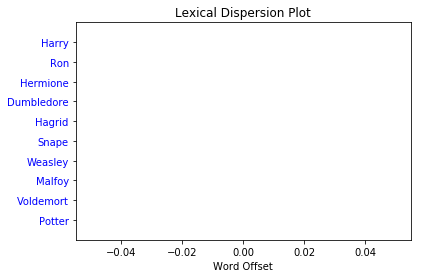

In [13]:
%matplotlib inline

# Tokens of all those books
all_books_t = list()
hp = ''

for b in books:
    all_books_t += books_clean[b]
    hp += books[b]

all_text = nltk.Text(all_books_t)
characters = extras['hp_characters_list']
characters = set([c.split()[0] for c in extras['hp_characters_list']] +
                 [c.split()[-1] for c in extras['hp_characters_list']])
characters = [t for t in characters if t != 'The']

c_aux = {}

for c in characters:
    c_aux[c] = hp.count(c)

most_import_dudes = sorted(c_aux.items(), key=lambda kv: kv[1], reverse=True)
most_import_dudes = [t[0] for t in most_import_dudes[:10]]

all_text.dispersion_plot(most_import_dudes)

In [15]:
pos_words = pd.read_csv(
    '../data/positive-words.txt',
    sep='\n',
    header=None,
    names=['pos_words'],
    encoding='latin1'
)

neg_words = pd.read_csv(
    '../data/negative-words.txt',
    sep='\n',
    header=None,
    names=['neg_words'],
    encoding='latin1'
)

pos_words = list(pos_words['pos_words'])
neg_words = list(neg_words['neg_words'])

In [16]:
books_tokens = {book: books_clean[book] for book in books}

for bt in books_tokens:
    pos_count, neg_count = 0, 0

    for t in books_tokens[bt]:
        if t in pos_words:
            pos_count += 1
        elif t in neg_words:
            neg_count += 1

    print('Book {}: {} positive words / {} negative words'
          .format(bt, pos_count, neg_count))

Book hp1_sorcerers_stone: 1977 positive words / 2325 negative words


Book hp2_chamber_of_secrets: 2110 positive words / 2949 negative words


Book hp3_prisioner_of_azkaban: 2526 positive words / 3456 negative words


Book hp4_globet_of_fire: 5039 positive words / 6341 negative words


Book hp5_order_of_the_phoenix: 6604 positive words / 8732 negative words


Book hp6_half_blood_prince: 4709 positive words / 5776 negative words


Book hp7_deathly_hallows: 4947 positive words / 7216 negative words
